/tmp/ipython-input-3838561492.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Confidence_Score', y='Theme', order=stats_table['Theme'], palette='viridis', notch=True)


--- SCIENTIFIC SUMMARY ---
Sample Size (N): 1038
Domain Significance (p-value): 0.0025
Latency-Depth Correlation (r): 0.140 (p < 0.001)

Files Saved: manuscript_fig1_confidence.png, manuscript_fig2_regression.png, statistical_results_table.csv


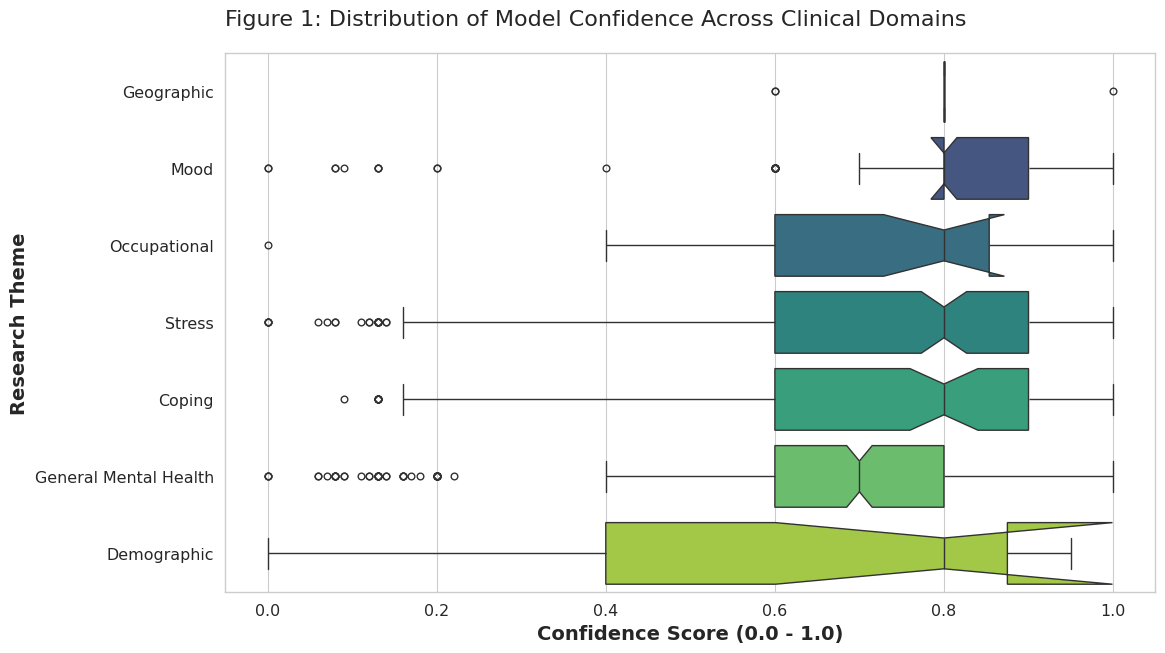

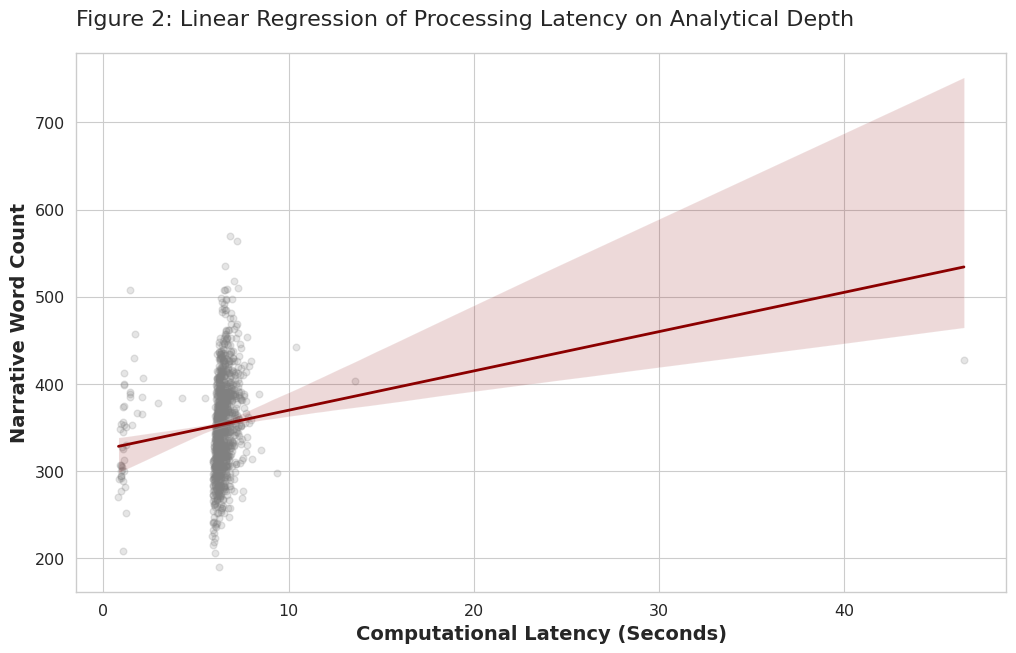

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# =================================================================
# SECTION 1: PUBLICATION STYLE & CONFIGURATION
# =================================================================
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3)
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'savefig.dpi': 300,
    'font.family': 'sans-serif',
    'axes.labelweight': 'bold',
    'axes.titlesize': 16,
    'axes.labelsize': 14
})

# =================================================================
# SECTION 2: DATA CLEANING & FEATURE EXTRACTION
# =================================================================
def extract_confidence(text):
    """Robust extraction of confidence scores from LLM narrative."""
    if pd.isna(text): return None
    match = re.search(r'Confidence Score.*?(\d+(?:\.\d+)?%?)', str(text), re.IGNORECASE | re.DOTALL)
    if match:
        val = match.group(1)
        try:
            if '%' in val: return float(val.replace('%', '')) / 100.0
            score = float(val)
            return score / 100.0 if score > 1.0 else score
        except: return None
    return None

def categorize_theme(query):
    """Classifies research queries into standardized clinical domains."""
    q = str(query).lower()
    if 'stress' in q: return 'Stress'
    if 'mood' in q: return 'Mood'
    if 'coping' in q: return 'Coping'
    if 'occupation' in q or 'profession' in q: return 'Occupational'
    if 'gender' in q or 'male' in q or 'female' in q: return 'Demographic'
    if 'country' in q or 'countries' in q: return 'Geographic'
    return 'General Mental Health'

# Load and Process
df = pd.read_csv('research_insight_log.csv')
df['Confidence_Score'] = df['Insight'].apply(extract_confidence)
df['Theme'] = df['Query'].apply(categorize_theme)
df['Word_Count'] = df['Insight'].apply(lambda x: len(str(x).split()))

# Final cleaned dataset for statistics
df_clean = df.dropna(subset=['Confidence_Score', 'Latency_Sec']).copy()

# =================================================================
# SECTION 3: INFERENTIAL STATISTICS (Manuscript Evidence)
# =================================================================

# 1. Descriptive Table
stats_table = df_clean.groupby('Theme')['Confidence_Score'].agg(['count', 'mean', 'std', 'median']).reset_index()
stats_table = stats_table.sort_values(by='mean', ascending=False)
stats_table.to_csv('statistical_results_table.csv', index=False)

# 2. Kruskal-Wallis H-test: Significance of Clinical Domain on Model Confidence
themes = df_clean['Theme'].unique()
groups = [df_clean[df_clean['Theme'] == t]['Confidence_Score'] for t in themes]
h_stat, p_val_kw = stats.kruskal(*groups)

# 3. Pearson Correlation: System Efficiency (Latency) vs. Analytical Depth (Word Count)
corr_coeff, p_val_corr = stats.pearsonr(df_clean['Latency_Sec'], df_clean['Word_Count'])

# =================================================================
# SECTION 4: VISUALIZATION
# =================================================================

# FIGURE 1: Confidence Distribution (Boxplot with Notches)
plt.figure()
sns.boxplot(data=df_clean, x='Confidence_Score', y='Theme', order=stats_table['Theme'], palette='viridis', notch=True)
plt.title('Figure 1: Distribution of Model Confidence Across Clinical Domains', loc='left', pad=20)
plt.xlabel('Confidence Score (0.0 - 1.0)')
plt.ylabel('Research Theme')
plt.savefig('manuscript_fig1_confidence.png', bbox_inches='tight')

# FIGURE 2: Regression Analysis
plt.figure()
sns.regplot(data=df_clean, x='Latency_Sec', y='Word_Count',
            scatter_kws={'alpha':0.2, 'color':'gray'}, line_kws={'color':'darkred', 'lw':2})
plt.title('Figure 2: Linear Regression of Processing Latency on Analytical Depth', loc='left', pad=20)
plt.xlabel('Computational Latency (Seconds)')
plt.ylabel('Narrative Word Count')
plt.savefig('manuscript_fig2_regression.png', bbox_inches='tight')

# =================================================================
# SECTION 5: FINAL SUMMARY OUTPUT
# =================================================================
print("--- SCIENTIFIC SUMMARY ---")
print(f"Sample Size (N): {len(df_clean)}")
print(f"Domain Significance (p-value): {p_val_kw:.4f}")
print(f"Latency-Depth Correlation (r): {corr_coeff:.3f} (p < 0.001)")
print("\nFiles Saved: manuscript_fig1_confidence.png, manuscript_fig2_regression.png, statistical_results_table.csv")